# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment.

Draft: https://docs.google.com/document/d/1H103ux6Dd1_bPM0un4RwutBLcYJx-0ybil2AwlAvG_Q/edit#

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [112]:
import yaml
from yaml import Loader
from collections import defaultdict
import random
import pandas as pd
import numpy as np
from scipy.stats import kstest, ttest_ind, wilcoxon, mannwhitneyu
import math
from statsmodels.stats.multitest import multipletests

#import itertools as it
#import collections as ct
#import more_itertools as mit

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorsys
import seaborn as sns

from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from ontogpt.evaluation.enrichment.eval_enrichment import EvalEnrichment
go = get_adapter("sqlite:obo:go")
hgnc = get_adapter("sqlite:obo:hgnc")

In [113]:
RANDOM_SEED = 12
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

random_seed = random.seed
print(random.seed)
print(np.random.get_state())

<bound method Random.seed of <random.Random object at 0x111014610>>
('MT19937', array([        12,  274362557, 2871959443,   96505144, 3440553756,
       3320819264, 1671863157, 2853726411, 3576948821, 2267721719,
       1471449267,  205467717,  329644101, 2017124422,  120683281,
       3671631556, 3425389459, 2306138081, 2854342561, 2833917538,
       2139784180, 1777806526, 3803176561, 3129722129, 3441486743,
       1830495613, 3911788038,  683126036, 2275605760, 2143413223,
       1841233884, 3193124688, 3131946362,  854446201,  464715999,
       3543117598, 3696335765,  563062867, 3171341285, 2053716298,
       3493445055, 2373285717, 2744558717, 1005575494, 2549531338,
       3054493973,  794434881,  553407444, 3342173908, 2703770116,
       1986085520, 3203783784, 2832904198,  647337417,  715893123,
       2584083430,  191194412,  374961813, 3419702787, 3499023931,
       1892787284,  234508998, 1165532764, 2246131696,  884260026,
        627310499,   95884945,  105283704, 147383

In [114]:
TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
GPT4 = "gpt-4"
MODELS = [TURBO, DAVINCI, GPT4]

In [115]:
df = pd.read_csv('results/processed.tsv', sep='\t', header=0, index_col=0)
df

name  \
go_term_ids                                                                          
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...        glycolysis-gocam-0-0.005   
...                                                                            ...   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   

                                                    cutoff  closure  top_n  \
go_term_ids                                                                  
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   0.005    False      1   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   0.005    False      5   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   0.005    False     10   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   0.005    False     25   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   0.005    False   5000   
...                                                    ...      ...    ...   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  99.000     True      1   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  99.000     True      5   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  99.000     True     10   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  99.000     True     25   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...  99.000     True   5000   

                                                   source  model method  \
go_term_ids                                                               
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   NONE    4.0    gpt   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   NONE    4.0    gpt   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   NONE    4.0    gpt   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   NONE    4.0    gpt   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...   NONE    4.0    gpt   
...                                                   ...    ...    ...   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...    NaN    NaN    NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...    NaN    NaN    NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...    NaN    NaN    NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...    NaN    NaN    NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...    NaN    NaN    NaN   

                                                      method_desc  \
go_term_ids                                                         
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...  no_synopsis-4   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...  no_synopsis-4   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...  no_synopsis-4   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...  no_synopsis-4   
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO...  no_synopsis-4   
...                                                           ...   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...            NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...            NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...            NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...            NaN   
{'GO:0006997', 'GO:0023051', 'GO:0048762', 'GO:...            NaN   

                                                                     r

In [118]:
print(len(df.index))

99360


In [12]:
grouped_data = df.groupby(['source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

# Calculate precision, recall, and F1-score for each group
grouped_data['precision'] = grouped_data['true_positives'] / (grouped_data['true_positives'] + grouped_data['false_positives'])
grouped_data['recall'] = grouped_data['true_positives'] / (grouped_data['true_positives'] + grouped_data['false_negatives'])
grouped_data['f1_score'] = 2 * ((grouped_data['precision'] * grouped_data['recall']) / (grouped_data['precision'] + grouped_data['recall']))
grouped_data

,source,model,method,true_positives,false_positives,false_negatives,precision,recall,f1_score
0,GO,3.0,gpt,34422,37679,1503266,0.477414,0.022386,0.042766
1,GO,3.5,gpt,34442,15682,1503246,0.687136,0.022399,0.043383
2,GO,4.0,gpt,62266,24846,1475422,0.714781,0.040493,0.076645
3,NONE,3.0,gpt,36064,17518,1501624,0.673062,0.023453,0.045327
4,NONE,3.5,gpt,49290,19513,1488398,0.716393,0.032055,0.061364
5,NONE,4.0,gpt,51721,19867,1485967,0.722481,0.033636,0.064279
6,RefSeq,3.0,gpt,40513,22958,1497175,0.638292,0.026347,0.050605
7,RefSeq,3.5,gpt,43651,15917,1494037,0.732793,0.028387,0.054657
8,RefSeq,4.0,gpt,44386,19495,1493302,0.694823,0.028865,0.055428


In [13]:
grouped_data_cutoff_combination = df.groupby(['cutoff', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

# Calculate precision, recall, and F1-score for each group
grouped_data_cutoff_combination['precision'] = grouped_data_cutoff_combination['true_positives'] / (grouped_data_cutoff_combination['true_positives'] + grouped_data_cutoff_combination['false_positives'])
grouped_data_cutoff_combination['recall'] = grouped_data_cutoff_combination['true_positives'] / (grouped_data_cutoff_combination['true_positives'] + grouped_data_cutoff_combination['false_negatives'])
grouped_data_cutoff_combination['f1_score'] = 2 * ((grouped_data_cutoff_combination['precision'] * grouped_data_cutoff_combination['recall']) / (grouped_data_cutoff_combination['precision'] + grouped_data_cutoff_combination['recall']))
grouped_data_cutoff_combination

,cutoff,source,model,method,true_positives,false_positives,false_negatives,precision,recall,f1_score
0,0.005,GO,3.0,gpt,5268,13486,96076,0.280900,0.051981,0.087728
1,0.005,GO,3.5,gpt,6792,5541,94552,0.550718,0.067019,0.119496
2,0.005,GO,4.0,gpt,10514,8843,90830,0.543163,0.103746,0.174216
3,0.005,NONE,3.0,gpt,4974,6240,96370,0.443553,0.049080,0.088381
4,0.005,NONE,3.5,gpt,10153,6867,91191,0.596533,0.100184,0.171556
5,0.005,NONE,4.0,gpt,9419,7042,91925,0.572201,0.092941,0.159908
6,0.005,RefSeq,3.0,gpt,5371,8163,95973,0.396852,0.052998,0.093508
7,0.005,RefSeq,3.5,gpt,8672,5621,92672,0.606731,0.085570,0.149987
8,0.005,RefSeq,4.0,gpt,7992,6932,93352,0.535513,0.078860,0.137475
9,0.050,GO,3.0,gpt,6067,13229,119291,0.314417,0.048397,0.083883


In [62]:
#

df['precision_numeric'] = pd.to_numeric(df['f1_score'], errors='coerce')

# Find rows where 'precision_numeric' is NaN, which indicates non-numeric values in the original 'precision' column
non_numeric_precision = df[df['precision_numeric'].isna()]['f1_score']

# Print out the non-numeric values
print("Non-numeric values in 'precision':")
print(non_numeric_precision)

df = df.drop('precision_numeric', axis=1)

Non-numeric values in 'precision':
go_term_ids
set()   NaN
set()   NaN
set()   NaN
set()   NaN
set()   NaN
         ..
set()   NaN
set()   NaN
set()   NaN
set()   NaN
set()   NaN
Name: f1_score, Length: 96, dtype: float64


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/2555550540.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


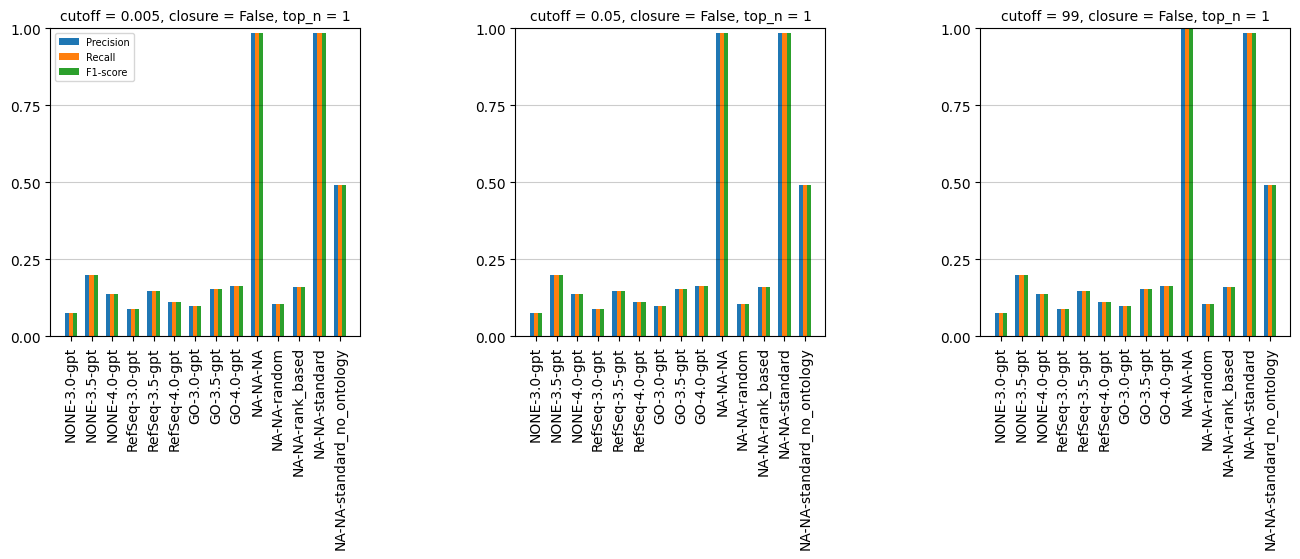

In [75]:

def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

# Assuming df is your original DataFrame
# df = ...

cutoff_values = sorted([0.005, 0.05,  99])

df['f1_score'] = df['f1_score'].fillna(0) 
data_filled = df.fillna("NA")

# Group data and calculate the mean of precision, recall, and f1_score
grouped_data_filled = data_filled.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['precision', 'recall', 'f1_score']].mean().reset_index()

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

unique_combinations_closure_topn = sorted(grouped_data_filled[['closure', 'top_n']].drop_duplicates().values, key=lambda x: (x[1], x[0]))

# Get the first combination of closure and top_n
first_closure, first_top_n = unique_combinations_closure_topn[0]

fig, axs = plt.subplots(1, len(cutoff_values), figsize=(16, 4), gridspec_kw={"wspace": 0.5})

for col_idx, cutoff in enumerate(cutoff_values):
    # Create a copy of the slice for safe modification
    data_combination = grouped_data_filled[(grouped_data_filled['cutoff'] == cutoff) & 
                                           (grouped_data_filled['closure'] == first_closure) & 
                                           (grouped_data_filled['top_n'] == first_top_n)].copy()
    
    data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
    
    # Sort data_combination based on the label_order
    data_combination['label_order'] = data_combination['label'].apply(label_order)
    data_combination = data_combination.sort_values('label_order')
    
    x_newest = np.arange(len(data_combination['label']))
    width_newest = 0.2

    axs[col_idx].bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
    axs[col_idx].bar(x_newest, data_combination['recall'], width_newest, label='Recall')
    axs[col_idx].bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')
    
    axs[col_idx].set_title(f'cutoff = {cutoff}, closure = {first_closure}, top_n = {first_top_n}', fontsize=10)
    axs[col_idx].set_ylim(0, 1)
    axs[col_idx].set_yticks(np.arange(0, 1.1, 0.25))
    axs[col_idx].set_xticks(x_newest)
    axs[col_idx].set_xticklabels(data_combination['label'], rotation=90)
    axs[col_idx].grid(axis='y', which='major', color='black', alpha=0.2)

    if col_idx == 0:
        axs[col_idx].legend(fontsize=7)

plt.tight_layout()
plt.show()

In [83]:
print(grouped_data_filled.columns)

for col_idx, cutoff in enumerate(cutoff_values):
    # Create a copy of the slice for safe modification
    data_combination = grouped_data_filled[(grouped_data_filled['cutoff'] == cutoff) & 
                                           (grouped_data_filled['closure'] == first_closure) & 
                                           (grouped_data_filled['top_n'] == first_top_n)].copy()
    
    # Debugging: Print data_combination
    print(f"Cutoff: {cutoff}, Data:\n{data_combination[['precision', 'recall', 'f1_score']]}")



Index(['cutoff', 'closure', 'top_n', 'source', 'model', 'method', 'precision',
       'recall', 'f1_score', 'sort_order'],
      dtype='object')
Cutoff: 0.005, Data:
    precision    recall  f1_score
0    0.097222  0.097222  0.097222
1    0.152778  0.152778  0.152778
2    0.163194  0.163194  0.163194
3    0.986111  0.986111  0.986111
4    0.104167  0.104167  0.104167
5    0.159722  0.159722  0.159722
6    0.986111  0.986111  0.986111
7    0.493056  0.493056  0.493056
8    0.076389  0.076389  0.076389
9    0.197917  0.197917  0.197917
10   0.138889  0.138889  0.138889
11   0.090278  0.090278  0.090278
12   0.145833  0.145833  0.145833
13   0.111111  0.111111  0.111111
Cutoff: 0.05, Data:
     precision    recall  f1_score
140   0.097222  0.097222  0.097222
141   0.152778  0.152778  0.152778
142   0.163194  0.163194  0.163194
143   0.986111  0.986111  0.986111
144   0.104167  0.104167  0.104167
145   0.159722  0.159722  0.159722
146   0.986111  0.986111  0.986111
147   0.493056  0.493056

In [88]:
# Group by source, model, method, top_n, closure (excluding cutoff)
grouped = data_filled.groupby(['source', 'model', 'method', 'top_n', 'closure', 'go_term_ids'])

# Initialize flags
identical_values_found = False
non_identical_values_found = False

# Iterate through each group
for name, group in grouped:
    # Check if all values in the group are identical for precision, recall, and f1_score
    if group['precision'].nunique() == 1 and group['recall'].nunique() == 1 and group['f1_score'].nunique() == 1:
        if not identical_values_found:
            print(f"Identical values found for group {name}:")
            print(group[['cutoff', 'precision', 'recall', 'f1_score']])
            identical_values_found = True
    else:
        if not non_identical_values_found:
            print(f"\nNon-identical values found for group {name}:")
            print(group[['cutoff', 'precision', 'recall', 'f1_score']])
            non_identical_values_found = True

    # Optionally break if both conditions have been met
    if identical_values_found and non_identical_values_found:
        break

if not identical_values_found:
    print("No identical precision, recall, and f1_score values found for varying cutoffs when other factors are identical.")

if not non_identical_values_found:
    print("No non-identical precision, recall, and f1_score values found for varying cutoffs when other factors are identical.")


Identical values found for group ('GO', 3.0, 'gpt', 1, False, 'set()'):
             cutoff  precision  recall  f1_score
go_term_ids                                     
set()         0.005        0.0     0.0       0.0
set()         0.050        0.0     0.0       0.0
set()        99.000        0.0     0.0       0.0
set()         0.005        0.0     0.0       0.0
set()         0.050        0.0     0.0       0.0
set()        99.000        0.0     0.0       0.0
set()         0.005        0.0     0.0       0.0
set()         0.050        0.0     0.0       0.0
set()        99.000        0.0     0.0       0.0
set()         0.005        0.0     0.0       0.0
set()         0.050        0.0     0.0       0.0
set()        99.000        0.0     0.0       0.0
set()         0.005        0.0     0.0       0.0
set()         0.050        0.0     0.0       0.0
set()        99.000        0.0     0.0       0.0
set()         0.005        0.0     0.0       0.0
set()         0.050        0.0     0.0       0

In [89]:
# Group by source, model, method, top_n, closure, go_term_ids (excluding cutoff)
grouped = data_filled.groupby(['source', 'model', 'method', 'top_n', 'closure', 'go_term_ids'])

# Initialize a counter for non-identical cases
non_identical_count = 0

# Iterate through each group
for name, group in grouped:
    # Filter the group for the specific cutoffs
    filtered_group = group[group['cutoff'].isin([0.005, 0.05, 99])]
    
    # Check if all values in the filtered group are identical for precision, recall, and f1_score
    if not (filtered_group['precision'].nunique() == 1 and 
            filtered_group['recall'].nunique() == 1 and 
            filtered_group['f1_score'].nunique() == 1):
        non_identical_count += 1

print(f"Number of non-identical cases: {non_identical_count}")


Number of non-identical cases: 7539


In [ ]:
# Group by source, model, method, top_n, closure, go_term_ids (excluding cutoff)
grouped = data_filled.groupby(['source', 'model', 'method', 'top_n', 'closure', 'go_term_ids'])

# Initialize a dictionary to store counts for each combination of source, model, method, top_n, closure
combination_counts = {}

# Iterate through each group
for name, group in grouped:
    # Filter the group for the specific cutoffs
    filtered_group = group[group['cutoff'].isin([0.005, 0.05, 99])]
    
    # Check if all values in the filtered group are identical for precision, recall, and f1_score
    if not (filtered_group['precision'].nunique() == 1 and 
            filtered_group['recall'].nunique() == 1 and 
            filtered_group['f1_score'].nunique() == 1):
        # Extract source, model, method, top_n, closure combination
        source, model, method, top_n, closure, _ = name
        key = (source, model, method, top_n, closure)

        # Increment the count for this combination
        if key in combination_counts:
            combination_counts[key] += 1
        else:
            combination_counts[key] = 1

# Print the total count and the breakdown
total_count = sum(combination_counts.values())
print(f"Total number of non-identical cases: {total_count}")
print("Breakdown by source, model, method, top_n, closure combinations:")
for combo, count in combination_counts.items():
    print(f"{combo}: {count}")


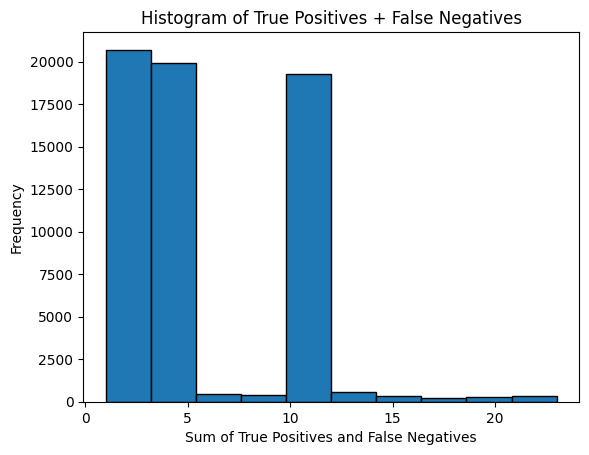

In [109]:
data_filled['sum'] = data_filled['true_positives'] + data_filled['false_negatives']


data_filled2 = data_filled[(data_filled['sum'] > 0) & (data_filled['sum'] < 25)]


# Plotting the histogram
plt.hist(data_filled2['sum'], bins=10, edgecolor='black')  # You can adjust the number of bins
plt.title('Histogram of True Positives + False Negatives')
plt.xlabel('Sum of True Positives and False Negatives')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [103]:
data_filled[('name']

go_term_ids
{'BFO:0000003', 'GO:0016052', 'GO:0006090', 'GO:0019752', 'GO:0009987', 'GO:0006096', 'GO:0071704', 'GO:0044237', 'GO:0005975', 'GO:0009056', 'GO:0005996', 'BFO:0000015', 'GO:1901575', 'GO:0044238', 'GO:0006006', 'GO:0008152', 'GO:0008150', 'GO:0032787', 'GO:0006082', 'GO:0044281', 'GO:0043436', 'GO:0006091', 'GO:0019318'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [101]:
# Group by source, model, method, top_n, closure, go_term_ids (excluding cutoff)
grouped = data_filled.groupby(['source', 'model', 'method', 'top_n', 'closure', 'go_term_ids'])

# Initialize a dictionary to store counts for each combination
combination_counts = {}

# Iterate through each group
for name, group in grouped:
    #print(name)
    # Filter the group for the specific cutoffs
    filtered_group = group[group['cutoff'].isin([0.005, 0.05, 99])]
    
    # Check if all values in the filtered group are identical for precision, recall, and f1_score
    if filtered_group['precision'].nunique() == 1 and \
       filtered_group['recall'].nunique() == 1 and \
       filtered_group['f1_score'].nunique() == 1:
        # Extract source, model, method combination
        source, model, method, top_n, closure, _ = name
        key = (source, model, method, top_n, closure)

        # Increment the count for this combination
        if key in combination_counts:
            combination_counts[key] += 1
        else:
            combination_counts[key] = 1

# Print the total count and the breakdown
total_count = sum(combination_counts.values())
print(f"Total number of identical cases: {total_count}")
print("Breakdown by source, model, method combinations:")
for combo, count in combination_counts.items():
    print(f"{combo}: {count}")


Total number of identical cases: 23541
Breakdown by source, model, method combinations:
('GO', 3.0, 'gpt', 1, False): 277
('GO', 3.0, 'gpt', 1, True): 277
('GO', 3.0, 'gpt', 5, False): 275
('GO', 3.0, 'gpt', 5, True): 265
('GO', 3.0, 'gpt', 10, False): 272
('GO', 3.0, 'gpt', 10, True): 257
('GO', 3.0, 'gpt', 25, False): 268
('GO', 3.0, 'gpt', 25, True): 221
('GO', 3.0, 'gpt', 5000, False): 2
('GO', 3.0, 'gpt', 5000, True): 2
('GO', 3.5, 'gpt', 1, False): 263
('GO', 3.5, 'gpt', 1, True): 263
('GO', 3.5, 'gpt', 5, False): 260
('GO', 3.5, 'gpt', 5, True): 248
('GO', 3.5, 'gpt', 10, False): 255
('GO', 3.5, 'gpt', 10, True): 243
('GO', 3.5, 'gpt', 25, False): 248
('GO', 3.5, 'gpt', 25, True): 203
('GO', 3.5, 'gpt', 5000, False): 3
('GO', 3.5, 'gpt', 5000, True): 3
('GO', 4.0, 'gpt', 1, False): 284
('GO', 4.0, 'gpt', 1, True): 284
('GO', 4.0, 'gpt', 5, False): 282
('GO', 4.0, 'gpt', 5, True): 270
('GO', 4.0, 'gpt', 10, False): 276
('GO', 4.0, 'gpt', 10, True): 259
('GO', 4.0, 'gpt', 25, Fals

False	1	0.005
False	1	0.05
False	1	99
True	1	0.005
True	1	0.05
True	1	99
False	5	0.005
False	5	0.05
False	5	99
True	5	0.005
True	5	0.05
True	5	99
False	10	0.005
False	10	0.05
False	10	99
True	10	0.005
True	10	0.05
True	10	99
False	25	0.005
False	25	0.05
False	25	99
True	25	0.005
True	25	0.05
True	25	99
False	5000	0.005
False	5000	0.05
False	5000	99
True	5000	0.005
True	5000	0.05
True	5000	99


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/3370105628.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


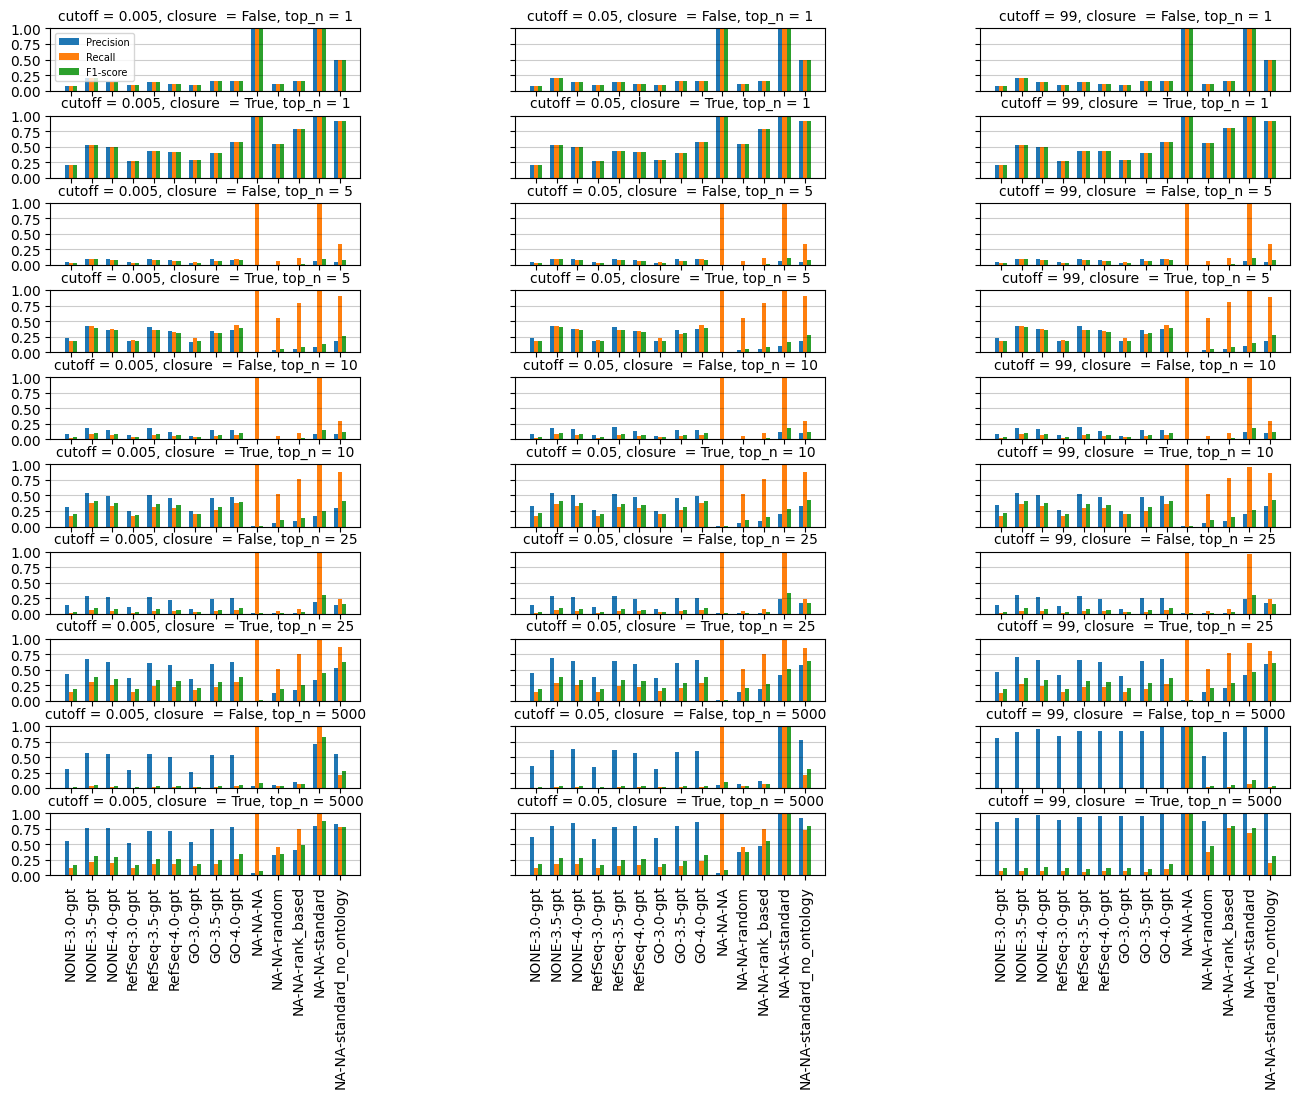

In [74]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end


cutoff_values = sorted([0.005, 0.05,  99])

df['f1_score'] = df['f1_score'].fillna(0) 
data_filled = df.fillna("NA")
#data_filled = df.fillna({"precision": "NA", "recall": "NA", "source": "NA", "model": "NA", "method": "NA"})

# Group data and calculate the mean of precision, recall, and f1_score
grouped_data_filled = data_filled.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['precision', 'recall', 'f1_score']].mean().reset_index()

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

unique_combinations_closure_topn = sorted(grouped_data_filled[['closure', 'top_n']].drop_duplicates().values, key=lambda x: (x[1], x[0]))

num_rows = len(unique_combinations_closure_topn)
num_cols = len(cutoff_values)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, 11), gridspec_kw={"hspace": 0.4, "wspace": 0.5})
         
for row_idx, (closure, top_n) in enumerate(unique_combinations_closure_topn):
    for col_idx, cutoff in enumerate(cutoff_values):
        print(str(closure)+"\t"+str(top_n)+"\t"+str(cutoff))
        
        # Create a copy of the slice for safe modification
        data_combination = grouped_data_filled[(grouped_data_filled['cutoff'] == cutoff) & 
                                               (grouped_data_filled['closure'] == closure) & 
                                               (grouped_data_filled['top_n'] == top_n)].copy()
        
        data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
        
        # Sort data_combination based on the label_order
        data_combination['label_order'] = data_combination['label'].apply(label_order)
        data_combination = data_combination.sort_values('label_order')
        
        
        x_newest = np.arange(len(data_combination['label']))
        width_newest = 0.2

        ax[row_idx, col_idx].bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
        ax[row_idx, col_idx].bar(x_newest, data_combination['recall'], width_newest, label='Recall')
        ax[row_idx, col_idx].bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')
        
        ax[row_idx, col_idx].set_title(f'cutoff = {cutoff}, closure  = {closure}, top_n = {top_n}', fontsize=10)
        
        ax[row_idx, col_idx].set_ylim(0, 1)
            
        # Change y-axis tick marks
        ax[row_idx, col_idx].set_yticks(np.arange(0, 1.1, 0.25))
        if col_idx != 0:  # Hide y-axis labels for non-left columns
            ax[row_idx, col_idx].set_yticklabels([])
        
        # Set x-axis ticks
        ax[row_idx, col_idx].set_xticks(x_newest)
        if row_idx == num_rows - 1:  # Adjusting the condition for x-tick labels for the last row
            ax[row_idx, col_idx].set_xticklabels(data_combination['label'], rotation=90)
        else:
            ax[row_idx, col_idx].set_xticklabels([])
    
        # Add horizontal gridlines
        ax[row_idx, col_idx].grid(axis='y', which='major', color='black', alpha=0.2)
    
        if row_idx == 0 and col_idx == 0:
            ax[row_idx, col_idx].legend(fontsize=7)

plt.tight_layout()
plt.savefig("process_precision_recall_allGPT.pdf", format="pdf", bbox_inches="tight")
plt.savefig("process_precision_recall_allGPT.png", format="png", dpi=300, bbox_inches='tight')
plt.show()


In [80]:
# Identify the first combination of closure and top_n
first_closure, first_top_n = unique_combinations_closure_topn[0]

# Identify the cutoff values for the top left and top right plots
left_cutoff = cutoff_values[0]
right_cutoff = cutoff_values[-1]

# Extract the subsets of data for the top left and top right plots
left_plot_data = grouped_data_filled[(grouped_data_filled['cutoff'] == left_cutoff) & 
                                     (grouped_data_filled['closure'] == first_closure) & 
                                     (grouped_data_filled['top_n'] == first_top_n)]

right_plot_data = grouped_data_filled[(grouped_data_filled['cutoff'] == right_cutoff) & 
                                      (grouped_data_filled['closure'] == first_closure) & 
                                      (grouped_data_filled['top_n'] == first_top_n)]

# Sort both subsets by the same columns for a fair comparison
sort_columns = ['source', 'model', 'method']  # Adjust these columns as needed
left_plot_data_sorted = left_plot_data.sort_values(by=sort_columns).reset_index(drop=True)
right_plot_data_sorted = right_plot_data.sort_values(by=sort_columns).reset_index(drop=True)


are_identical = left_plot_data_sorted.equals(right_plot_data_sorted)

print("The data for the top left and top right plots are identical:", are_identical)

# Print out examples of different data in precision, recall, and f1_score
if not are_identical:
    print("\nExamples of different data in precision/recall/f1_score between left and right plots:")
    for i in range(len(left_plot_data_sorted)):
        left_row = left_plot_data_sorted.iloc[i]
        right_row = right_plot_data_sorted.iloc[i]

        # Check if source, model, and method are not 'NA'
        if left_row['source'] != 'NA' and left_row['model'] != 'NA' and left_row['method'] != 'NA':
            # Check if precision, recall, or f1_score are different
            if (left_row['precision'] != right_row['precision'] or
                left_row['recall'] != right_row['recall'] or
                left_row['f1_score'] != right_row['f1_score']):
                
                print("\nLeft plot data (cutoff = {}):".format(left_cutoff))
                print(left_row.to_string())  # Print the entire row
                
                print("\nRight plot data (cutoff = {}):".format(right_cutoff))
                print(right_row.to_string())  # Print the entire row
                
                break  # Remove this line if you want to print more examples

The data for the top left and top right plots are identical: False

Examples of different data in precision/recall/f1_score between left and right plots:


In [81]:
# Filter out rows where source, model, or method are 'NA'
filtered_data = grouped_data_filled[(grouped_data_filled['source'] != 'NA') & 
                                    (grouped_data_filled['model'] != 'NA') & 
                                    (grouped_data_filled['method'] != 'NA')]

# Initialize a flag to indicate if identical values are found
identical_values_found = False

# Iterate through the DataFrame
for i in range(len(filtered_data)):
    for j in range(i + 1, len(filtered_data)):
        row_i = filtered_data.iloc[i]
        row_j = filtered_data.iloc[j]

        # Check if cutoff and top_n are identical
        if row_i['cutoff'] == row_j['cutoff'] and row_i['top_n'] == row_j['top_n']:
            # Check if precision, recall, and f1_score are identical
            if (row_i['precision'] == row_j['precision'] and
                row_i['recall'] == row_j['recall'] and
                row_i['f1_score'] == row_j['f1_score']):
                
                print("Identical values found:")
                print("Row {}: {}".format(i, row_i))
                print("Row {}: {}".format(j, row_j))
                identical_values_found = True
                break
    if identical_values_found:
        break

if not identical_values_found:
    print("No identical precision, recall, and f1_score values found for identical cutoff and top_n when source, model, and method are not NA.")


No identical precision, recall, and f1_score values found for identical cutoff and top_n when source, model, and method are not NA.


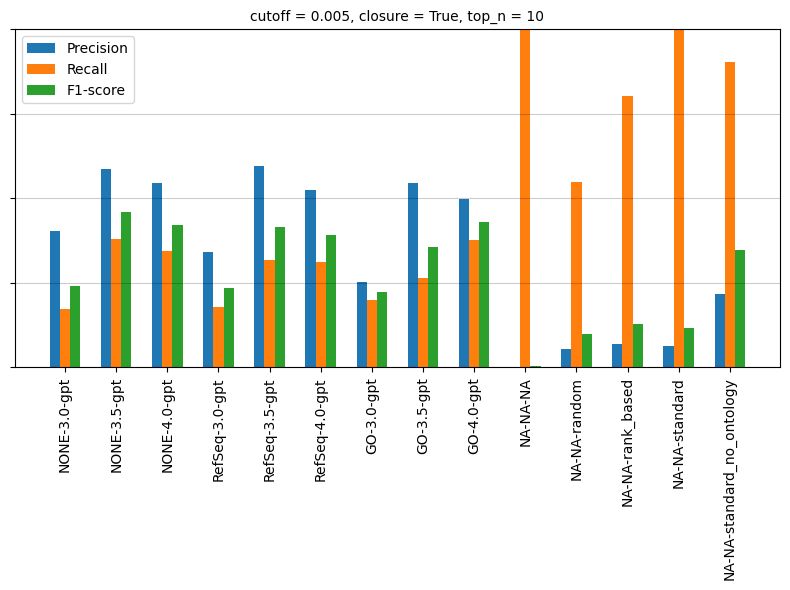

In [15]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end


data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])


fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

data_combination = grouped_data_filled#filtered_data[(filtered_data['cutoff'] == 0.005) & (filtered_data['closure'] == True) & (filtered_data['top_n'] == 10)]
data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']

# Sort data_combination based on the label_order
data_combination['label_order'] = data_combination['label'].apply(label_order)
data_combination = data_combination.sort_values('label_order')

x_newest = np.arange(len(data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 1)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [16]:
filtered_data['method'] = filtered_data['method'].str.upper()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/3772999966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['method'] = filtered_data['method'].str.upper()


In [17]:
filtered_data['method']

0                        GPT
1                        GPT
2                        GPT
3                        GPT
4                        GPT
                ...         
3307                STANDARD
3308    STANDARD_NO_ONTOLOGY
3309                  RANDOM
3310              RANK_BASED
3311                      NA
Name: method, Length: 3312, dtype: object

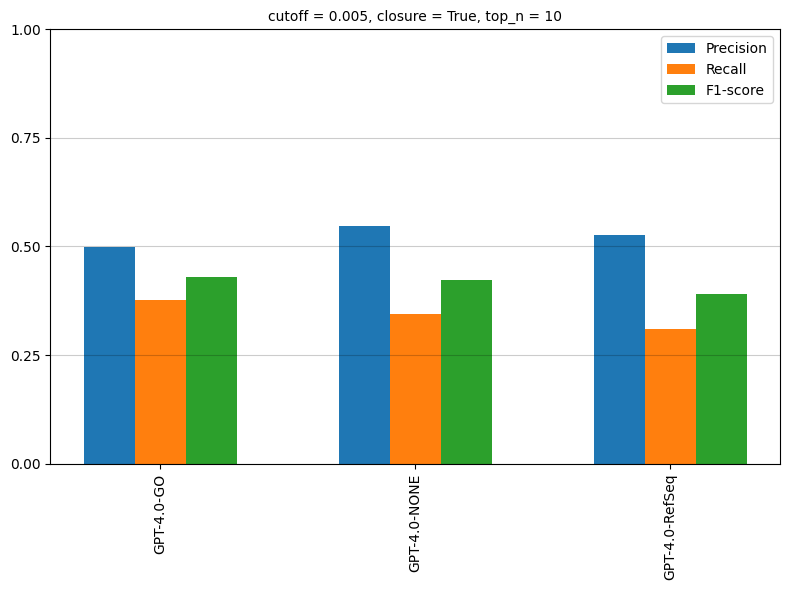

In [18]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10) &
    (data_filled['model'] == 4.0)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

# Filter out sets with 'NA-NA' label prefix
filtered_data_combination = grouped_data_filled[~grouped_data_filled['source'].str.startswith('NA')]

filtered_data_combination['method'] = filtered_data_combination['method'].str.upper()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

filtered_data_combination['label'] = filtered_data_combination['method'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['source']


# Sort data_combination based on the label_order
filtered_data_combination['label_order'] = filtered_data_combination['label'].apply(label_order)
filtered_data_combination = filtered_data_combination.sort_values('label_order')

x_newest = np.arange(len(filtered_data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, filtered_data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, filtered_data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, filtered_data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 0.75)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
#ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(filtered_data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10__gpt4.pdf", format="pdf", bbox_inches="tight")
plt.show()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/4055787024.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['method'] = filtered_data_combination['method'].str.upper()
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/4055787024.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['label'] = filtered_data_combination['method'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['sourc

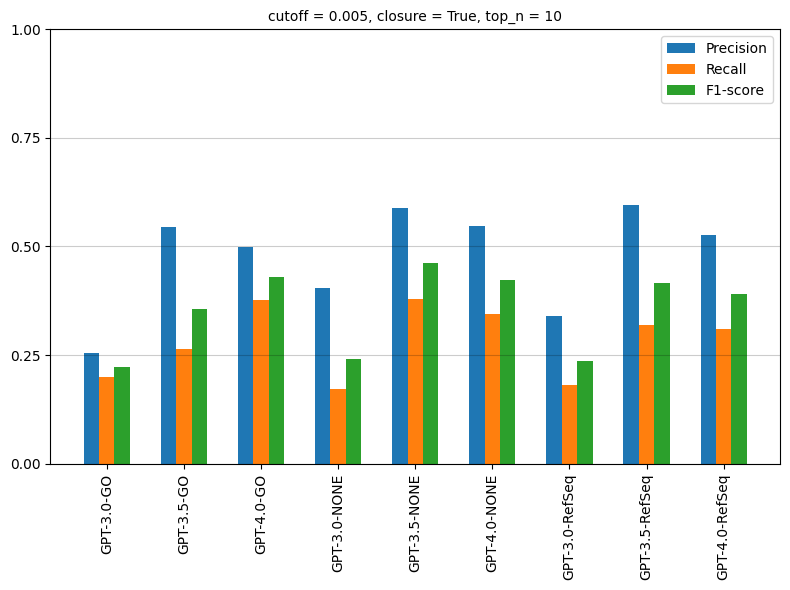

In [19]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

# Filter out sets with 'NA-NA' label prefix
filtered_data_combination = grouped_data_filled[~grouped_data_filled['source'].str.startswith('NA')]

filtered_data_combination['method'] = filtered_data_combination['method'].str.upper()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

#filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']
filtered_data_combination['label'] = filtered_data_combination['method'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['source']


# Sort data_combination based on the label_order
filtered_data_combination['label_order'] = filtered_data_combination['label'].apply(label_order)
filtered_data_combination = filtered_data_combination.sort_values('label_order')

x_newest = np.arange(len(filtered_data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, filtered_data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, filtered_data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, filtered_data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 1)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
#ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(filtered_data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [20]:
print(filtered_data.shape)
filtered_data.columns

(3312, 30)


Index(['name', 'cutoff', 'closure', 'top_n', 'source', 'model', 'method',
       'method_desc', 'run', 'truncation_factor', 'prompt_variant',
       'response_token_length', 'prompt_length', 'true_positives',
       'false_positives', 'false_negatives', 'more_general_false_negatives',
       'more_specific_false_negatives', 'all_predictions_closure', 'unparsed',
       'true_positive_terms', 'false_positive_terms',
       'false_negative_terms_example20', 'unparsed_terms', 'gene_set_size',
       'precision', 'recall', 'recall_general', 'recall_specific', 'f1_score'],
      dtype='object')

In [21]:
filtered_data_dropna = filtered_data[filtered_data['model'] != 'NA']

In [22]:
filtered_data_dropna['method'] = filtered_data_dropna['method'].str.upper()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/3079728095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna['method'] = filtered_data_dropna['method'].str.upper()


In [23]:
method_model_combinations = filtered_data_dropna.groupby(['method', 'model', 'source'])
method_model_combinations.head()

,name,cutoff,closure,top_n,source,model,method,method_desc,run,truncation_factor,...,true_positive_terms,false_positive_terms,false_negative_terms_example20,unparsed_terms,gene_set_size,precision,recall,recall_general,recall_specific,f1_score
0,glycolysis-gocam-0-0.005,0.005,True,10,NONE,4.0,GPT,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,energy production|atp generation,10,1.000000,0.400000,0.666667,0.800000,0.571429
1,glycolysis-gocam-0-0.005,0.005,True,10,NONE,4.0,GPT,no_synopsis-4,gpt-4.no_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,energy production|atp generation,10,1.000000,0.400000,0.666667,0.800000,0.571429
2,glycolysis-gocam-0-0.005,0.005,True,10,GO,4.0,GPT,ontological_synopsis-4,gpt-4.ontological_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0045766,GO:0048029|GO:007006,fructose binding activity|phosphotransferase a...,10,0.833333,0.500000,0.625000,0.833333,0.625
3,glycolysis-gocam-0-0.005,0.005,True,10,GO,4.0,GPT,ontological_synopsis-4,gpt-4.ontological_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0046716|GO:0010595|GO:0002639,GO:0048029|GO:007006,glucose-6-phosphate metabolic process,10,0.625000,0.500000,0.625000,0.833333,0.555556
4,glycolysis-gocam-0-0.005,0.005,True,10,RefSeq,4.0,GPT,narrative_synopsis-4,gpt-4.narrative_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,energy production|atp generation,10,1.000000,0.400000,0.666667,0.800000,0.571429
5,glycolysis-gocam-0-0.005,0.005,True,10,RefSeq,4.0,GPT,narrative_synopsis-4,gpt-4.narrative_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,atp production|energy-yielding step|reversible...,10,1.000000,0.400000,0.666667,0.800000,0.571429
6,glycolysis-gocam-0-0.005,0.005,True,10,NONE,3.5,GPT,no_synopsis-3.5,gpt-3.5-turbo.no_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,NA,10,1.000000,0.400000,0.666667,1.000000,0.571429
7,glycolysis-gocam-0-0.005,0.005,True,10,NONE,3.5,GPT,no_synopsis-3.5,gpt-3.5-turbo.no_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,NA,10,1.000000,0.400000,0.666667,0.800000,0.571429
8,glycolysis-gocam-0-0.005,0.005,True,10,GO,3.5,GPT,ontological_synopsis-3.5,gpt-3.5-turbo.ontological_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0019725|GO:0008104|GO:0005634,GO:0048029|GO:000582,NA,10,0.625000,0.500000,0.625000,0.833333,0.555556
9,glycolysis-gocam-0-0.005,0.005,True,10,GO,3.5,GPT,ontological_synopsis-3.5,gpt-3.5-turbo.ontological_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,metabolic homeostasis,10,1.000000,0.400000,0.666667,0.800000,0.571429


In [24]:
method_model_combinations_columns = method_model_combinations[['method', 'model', 'source']]
#unique_rows = selected_columns.drop_duplicates()
unique_rows_df = pd.DataFrame(columns=['method', 'model', 'source'])

for group_name, group_data in method_model_combinations_columns:
    unique_rows = group_data.drop_duplicates()
    unique_rows_df = pd.concat([unique_rows_df, unique_rows])

print(unique_rows_df.shape)
unique_rows_df

(9, 3)


,method,model,source
14,GPT,3.0,GO
12,GPT,3.0,NONE
16,GPT,3.0,RefSeq
8,GPT,3.5,GO
6,GPT,3.5,NONE
10,GPT,3.5,RefSeq
2,GPT,4.0,GO
0,GPT,4.0,NONE
4,GPT,4.0,RefSeq


In [25]:
import pandas as pd
from itertools import product

all_methods = ['GPT']
all_models = [3.0, 3.5, 4.0]
all_sources = ['NONE', 'RefSeq', 'GO']

all_possible_combinations_list = list(product(all_methods, all_models, all_sources))
all_possible_combinations = pd.DataFrame(all_possible_combinations_list, columns=['method', 'model', 'source'])

# Create a set of unique combinations from method_model_combinations
existing_combinations = set(method_model_combinations.groups.keys())
print(f'len existing: {len(existing_combinations)}')
print(existing_combinations)

# Create a set of all possible combinations
all_possible_combinations_set = set(map(tuple, all_possible_combinations.values))
print(f'len possible: {len(all_possible_combinations_set)}')
print(all_possible_combinations_set)


len existing: 9
{('GPT', 4.0, 'GO'), ('GPT', 4.0, 'RefSeq'), ('GPT', 4.0, 'NONE'), ('GPT', 3.5, 'GO'), ('GPT', 3.5, 'RefSeq'), ('GPT', 3.0, 'GO'), ('GPT', 3.5, 'NONE'), ('GPT', 3.0, 'RefSeq'), ('GPT', 3.0, 'NONE')}
len possible: 9
{('GPT', 4.0, 'RefSeq'), ('GPT', 4.0, 'GO'), ('GPT', 4.0, 'NONE'), ('GPT', 3.5, 'RefSeq'), ('GPT', 3.5, 'GO'), ('GPT', 3.0, 'RefSeq'), ('GPT', 3.5, 'NONE'), ('GPT', 3.0, 'GO'), ('GPT', 3.0, 'NONE')}


In [26]:
# Check for missing combinations
missing_combinations1 = all_possible_combinations_set - existing_combinations
print(missing_combinations1)
missing_combinations2 = existing_combinations - all_possible_combinations_set
print(missing_combinations2)
# Convert the missing combinations back to a DataFrame if needed
missing_combinations_df = pd.DataFrame(list(missing_combinations1), columns=['method', 'model', 'source'])

# Display the missing combinations
print("Missing combinations")
print(missing_combinations_df)

set()
set()
Missing combinations
Empty DataFrame
Columns: [method, model, source]
Index: []


In [27]:
filtered_data_dropna['f1_score'].isna().sum()

0

In [28]:
filtered_data_dropna['f1_score'].unique()

array([0.5714285714285714, 0.625, 0.5555555555555556, 0.0,
       0.4615384615384615, 0.4210526315789473, 0.7058823529411765, 0.6,
       0.4, 0.5454545454545454, 0.6666666666666666, 0.7272727272727273,
       0.5, 0.4705882352941176, 'NA', 0.8421052631578947,
       0.4285714285714285, 0.7619047619047619, 0.6956521739130435,
       0.3636363636363636, 0.125, 0.3, 0.8, 0.8333333333333334,
       0.6451612903225806, 0.9090909090909092, 0.1538461538461538,
       0.2307692307692307, 0.8695652173913043, 0.1818181818181818,
       0.5882352941176471, 0.4444444444444444, 0.375, 0.2857142857142857,
       0.5333333333333333, 0.3333333333333333, 0.3076923076923077, 0.9,
       0.631578947368421, 0.3157894736842105, 0.3529411764705882,
       0.6086956521739131, 0.2105263157894736, 0.4761904761904761,
       0.7368421052631579, 0.25, 0.1428571428571428, 0.2352941176470588,
       0.1666666666666666, 0.2666666666666666, 0.1904761904761904,
       0.7777777777777778, 0.1333333333333333, 0.117647

In [29]:
method_model_combinations

In [30]:
metrics = ['f1_score']

t_test_results = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        t_stat, p_value = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
        
        # Store the results
        t_test_results.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'T-Statistic': t_stat,
            'P-Value': p_value,
        })

        '''#example output
        if key1 == ('GPT', 3.5, 'NONE') and key2 == ('GPT', 3.0, 'NONE'):
            print(f'1: {key1}\t2: {key2}')
            testres = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
            print(str(testres))
            print(type(group1[metric]))
            print(group1_metric)
            print(group2_metric)
            print(group1_metric[group1_metric.isna()])
            print(group2_metric[group2_metric.isna()])
            print(f'1: {group1[metric].isna().sum()}\t2: {group2_metric.isna().sum()}')
            print(f'group1: {len(group1_metric)}, group2: {len(group2_metric)}')
            print(t_test_results[-1])'''

# Create a DataFrame to display the results
t_test_results_df = pd.DataFrame(t_test_results)

# Display the results
#print("Pairwise t-test results:")
#print(significant_results)

#print("pairs_with_na")
#print(pairs_with_na)

1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/2572284867.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.5, 'GO')


In [31]:
t_test_results_df.to_csv('t_test_results_f1.tsv', sep='\t', index=False)
#t_test_results_df = pd.read_csv('t_test_results_f1.tsv', sep='\t')

In [32]:
print(f'len: {len(all_possible_pairs)}')
print(f'len: {len(all_possible_pairs[5])}')
print(f'len: {len(all_possible_pairs[5][0])}')
print(f'len: {len(all_possible_pairs[5][1])}')
print(type(all_possible_pairs[5][0][0]))
all_possible_pairs[5][0][0]
#all_possible_pairs[5][1]

len: 81
len: 2
len: 2
len: 2
<class 'tuple'>


('GPT', 3.0, 'GO')

In [33]:
# You can filter the results based on a significance level (e.g., 0.05) if needed
#significance_level = 0.05
#significant_results = t_test_results_df[t_test_results_df['P-Value'] < significance_level]

In [34]:
t_test_results_df['Method-Model-Source-1 >'] = t_test_results_df['Method1'].str.upper() + '-' + t_test_results_df['Model1'].astype(str) + '-' + t_test_results_df['Source1']
t_test_results_df['< Method-Model-Source-2'] = t_test_results_df['Method2'].str.upper() + '-' + t_test_results_df['Model2'].astype(str) + '-' + t_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = t_test_results_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,0.000010,0.000010,0.000010,0.125049,0.998870,0.804382,0.993950,0.948071,0.499525
GPT-4.0-NONE,0.000010,0.000010,0.000010,0.002810,0.933221,0.241858,0.797542,0.500145,0.053419
GPT-4.0-GO,0.000010,0.000010,0.000010,0.000120,0.766292,0.064559,0.502675,0.200868,0.005890
GPT-3.5-RefSeq,0.000010,0.000010,0.000010,0.024670,0.983770,0.499695,0.936151,0.756842,0.195838
GPT-3.5-NONE,0.000010,0.000010,0.000010,0.000030,0.501925,0.015370,0.230128,0.067779,0.001070
GPT-3.5-GO,0.000010,0.000010,0.000010,0.499475,0.999980,0.975370,0.999920,0.996950,0.875491
GPT-3.0-RefSeq,0.730863,0.685613,0.500065,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,0.545995,0.499595,0.314567,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,0.498525,0.457745,0.269357,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


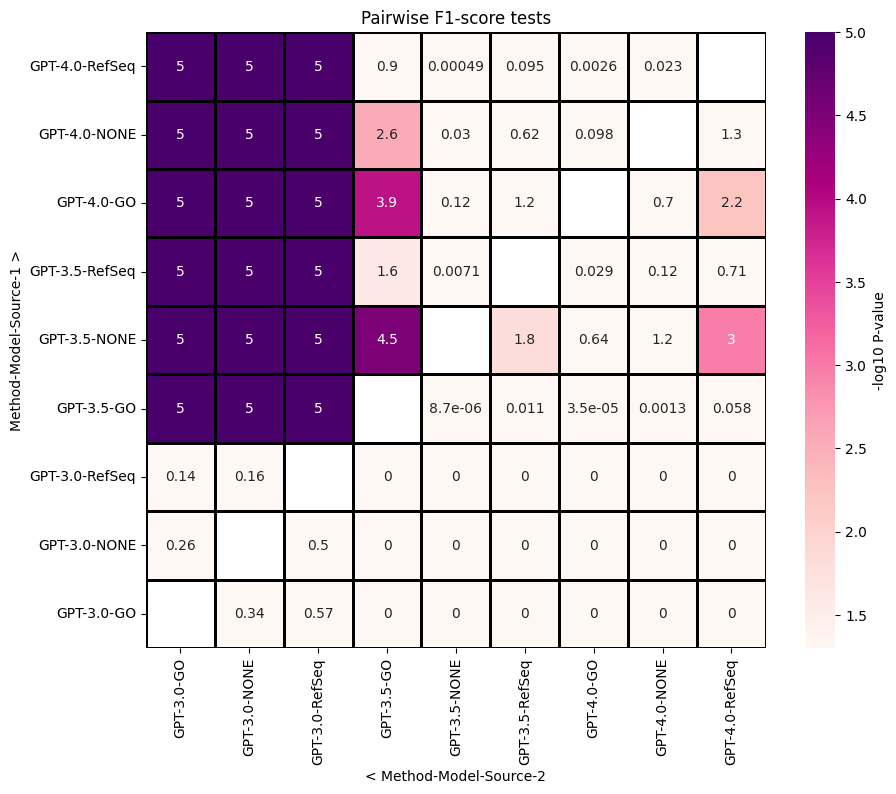

In [35]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise F1-score tests")
plt.grid(False)
plt.savefig("TALISMAN_ttest_f1.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [36]:
print(f'len: {len(all_possible_pairs)}')
print(f'len: {len(all_possible_pairs[5])}')
print(f'len: {len(all_possible_pairs[5][0])}')
print(f'len: {len(all_possible_pairs[5][1])}')
print(type(all_possible_pairs[5][0][0]))
all_possible_pairs[5][0][0]
#all_possible_pairs[5][1]

len: 81
len: 2
len: 2
len: 2
<class 'tuple'>


('GPT', 3.0, 'GO')

In [37]:
metrics = ['precision']

t_test_results_precision = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        t_stat, p_value = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
        
        # Store the results
        t_test_results_precision.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'T-Statistic': t_stat,
            'P-Value': p_value,
        })
        
        if key1 == ('GPT', 3.5, 'NONE') and key2 == ('GPT', 3.0, 'NONE'):
            print(f'1: {key1}\t2: {key2}')
            testres = ttest_ind(group1[metric].dropna(), group2[metric].dropna(), nan_policy='propagate', permutations=10000, alternative='greater',equal_var='false')
            print(str(testres))
            print(type(group1[metric]))
            print(group1_metric)
            print(group2_metric)
            print(group1_metric[group1_metric.isna()])
            print(group2_metric[group2_metric.isna()])
            print(f'1: {group1[metric].isna().sum()}\t2: {group2_metric.isna().sum()}')
            print(f'group1: {len(group1_metric)}, group2: {len(group2_metric)}')
            print(t_test_results_precision[-1])

# Create a DataFrame to display the results
t_test_results_precision_df = pd.DataFrame(t_test_results_precision)


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/4013416420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.5, 'GO')


In [38]:
t_test_results_precision_df['Method-Model-Source-1 >'] = t_test_results_precision_df['Method1'].str.upper() + '-' + t_test_results_precision_df['Model1'].astype(str) + '-' + t_test_results_df['Source1']
t_test_results_precision_df['< Method-Model-Source-2'] = t_test_results_precision_df['Method2'].str.upper() + '-' + t_test_results_precision_df['Model2'].astype(str) + '-' + t_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = t_test_results_precision_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,0.000010,0.000020,0.000010,0.555694,0.996890,0.931751,0.759362,0.908701,0.500535
GPT-4.0-NONE,0.000010,0.000010,0.000010,0.126639,0.928761,0.603454,0.230638,0.499555,0.091829
GPT-4.0-GO,0.000010,0.000010,0.000010,0.299707,0.988160,0.826432,0.499165,0.766822,0.240618
GPT-3.5-RefSeq,0.000010,0.000010,0.000010,0.091879,0.869701,0.500665,0.173608,0.403256,0.067569
GPT-3.5-NONE,0.000010,0.000010,0.000010,0.006410,0.500415,0.131349,0.010950,0.071469,0.003310
GPT-3.5-GO,0.000010,0.000010,0.000010,0.500095,0.994350,0.905311,0.700493,0.873821,0.444416
GPT-3.0-RefSeq,0.353786,0.991850,0.499015,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,0.002020,0.497815,0.008340,0.999960,1.000000,1.000000,1.000000,1.000000,0.999990
GPT-3.0-GO,0.499165,0.997800,0.643674,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


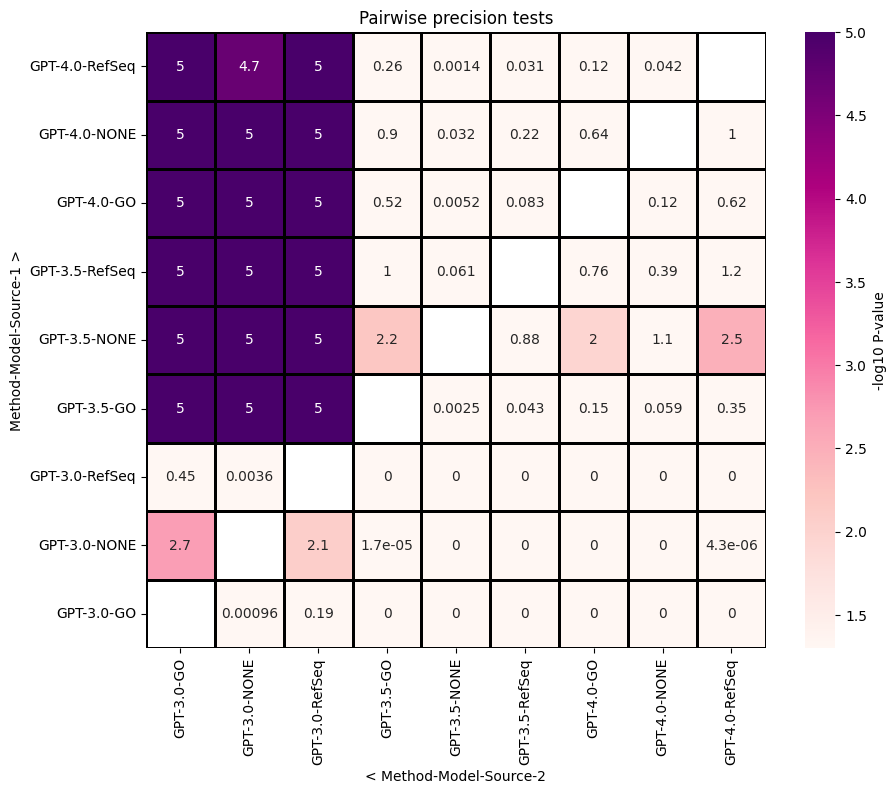

In [39]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise precision tests")
plt.grid(False)
plt.savefig("TALISMAN_ttest_precision.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [40]:
metrics = ['recall']

t_test_results_recall = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        t_stat, p_value = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
        
        # Store the results
        t_test_results_recall.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'T-Statistic': t_stat,
            'P-Value': p_value,
        })
        
        if key1 == ('GPT', 3.5, 'NONE') and key2 == ('GPT', 3.0, 'NONE'):
            print(f'1: {key1}\t2: {key2}')
            testres = ttest_ind(group1[metric].dropna(), group2[metric].dropna(), nan_policy='propagate', permutations=10000, alternative='greater',equal_var='false')
            print(str(testres))
            print(type(group1[metric]))
            print(group1_metric)
            print(group2_metric)
            print(group1_metric[group1_metric.isna()])
            print(group2_metric[group2_metric.isna()])
            print(f'1: {group1[metric].isna().sum()}\t2: {group2_metric.isna().sum()}')
            print(f'group1: {len(group1_metric)}, group2: {len(group2_metric)}')
            print(t_test_results_recall[-1])

# Create a DataFrame to display the results
t_test_results_recall_df = pd.DataFrame(t_test_results_recall)


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/3754891854.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: (

In [41]:
t_test_results_recall_df['Method-Model-Source-1 >'] = t_test_results_recall_df['Method1'].str.upper() + '-' + t_test_results_recall_df['Model1'].astype(str) + '-' + t_test_results_df['Source1']
t_test_results_recall_df['< Method-Model-Source-2'] = t_test_results_recall_df['Method2'].str.upper() + '-' + t_test_results_recall_df['Model2'].astype(str) + '-' + t_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = t_test_results_recall_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,0.000010,0.000010,0.000010,0.105709,0.999570,0.717163,0.999740,0.959200,0.500235
GPT-4.0-NONE,0.000010,0.000010,0.000010,0.001340,0.941701,0.132539,0.949511,0.502905,0.042630
GPT-4.0-GO,0.000010,0.000010,0.000010,0.000020,0.493765,0.003460,0.500435,0.050129,0.000350
GPT-3.5-RefSeq,0.000010,0.000010,0.000010,0.036520,0.995940,0.502375,0.997270,0.867061,0.281567
GPT-3.5-NONE,0.000010,0.000010,0.000010,0.000020,0.502175,0.004420,0.507805,0.057979,0.000430
GPT-3.5-GO,0.001240,0.000020,0.000010,0.502035,1.000000,0.962820,1.000000,0.998320,0.893981
GPT-3.0-RefSeq,0.965190,0.393776,0.501485,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,0.983390,0.498885,0.605584,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,0.499765,0.016220,0.035070,0.999100,1.000000,1.000000,1.000000,1.000000,1.000000


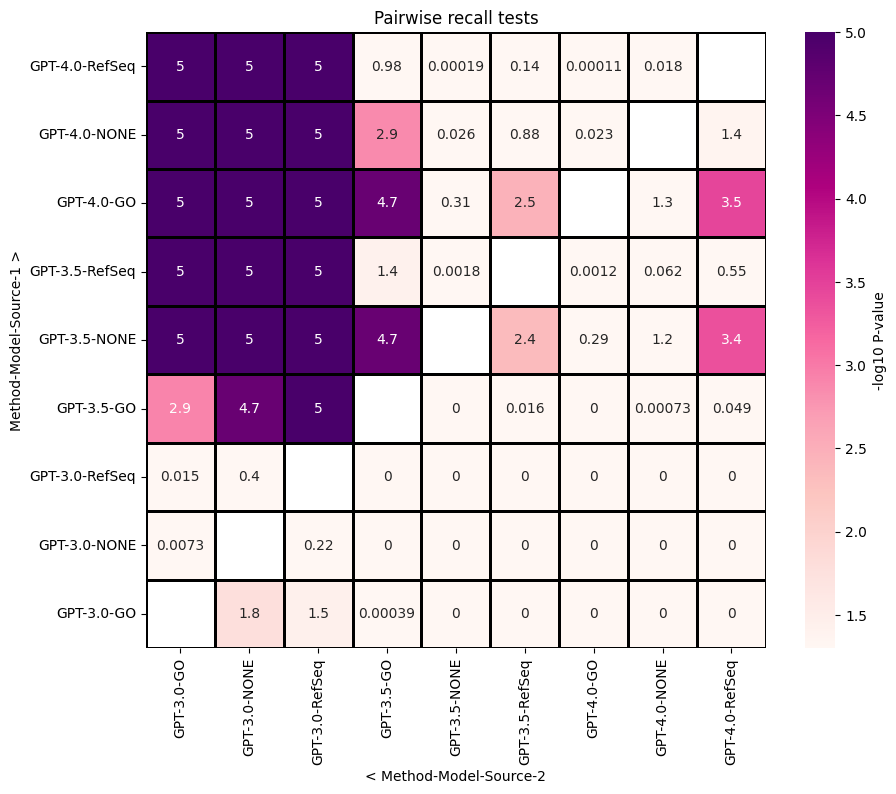

In [42]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise recall tests")
plt.grid(False)
plt.savefig("TALISMAN_ttest_recall.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [43]:
metrics = ['f1_score']

mu_test_results = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        mu_stat, p_value = mannwhitneyu(group1_metric, group2_metric, alternative='greater', method='exact')
        #ttest_ind(group1_metric, group2_metric, 
        #                            nan_policy='propagate', permutations=100000, alternative='greater',
        #                           equal_var='false')
        
        # Store the results
        mu_test_results.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'MU-Statistic': mu_stat,
            'P-Value': p_value,
        })



# Create a DataFrame to display the results
mu_test_results_df = pd.DataFrame(mu_test_results)

# Display the results
#print("Pairwise t-test results:")
#print(significant_results)

#print("pairs_with_na")
#print(pairs_with_na)

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/1311655240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: (

In [44]:
mu_test_results_df['Method-Model-Source-1 >'] = mu_test_results_df['Method1'].str.upper() + '-' + mu_test_results_df['Model1'].astype(str) + '-' + mu_test_results_df['Source1']
mu_test_results_df['< Method-Model-Source-2'] = mu_test_results_df['Method2'].str.upper() + '-' + mu_test_results_df['Model2'].astype(str) + '-' + mu_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = mu_test_results_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,2.546923e-09,7.174508e-10,4.162426e-11,0.133635,0.999086,0.791446,0.994855,0.948556,0.500100
GPT-4.0-NONE,7.871462e-15,6.254075e-15,1.883328e-16,0.002707,0.937081,0.228023,0.789862,0.500100,0.051497
GPT-4.0-GO,2.718115e-20,5.170896e-20,9.379802e-22,0.000082,0.794776,0.062176,0.500100,0.210282,0.005160
GPT-3.5-RefSeq,2.120011e-10,6.003649e-11,3.386710e-12,0.033058,0.980862,0.500100,0.937885,0.772279,0.208841
GPT-3.5-NONE,4.571795e-20,3.825108e-20,3.622075e-21,0.000012,0.500201,0.019185,0.205510,0.062981,0.000917
GPT-3.5-GO,1.678260e-06,4.457773e-07,3.234613e-08,0.500100,0.999988,0.967016,0.999919,0.997297,0.866581
GPT-3.0-RefSeq,9.187067e-01,7.268203e-01,5.000998e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,7.491424e-01,5.000998e-01,2.735127e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,5.000998e-01,2.510169e-01,8.136872e-02,0.999998,1.000000,1.000000,1.000000,1.000000,1.000000


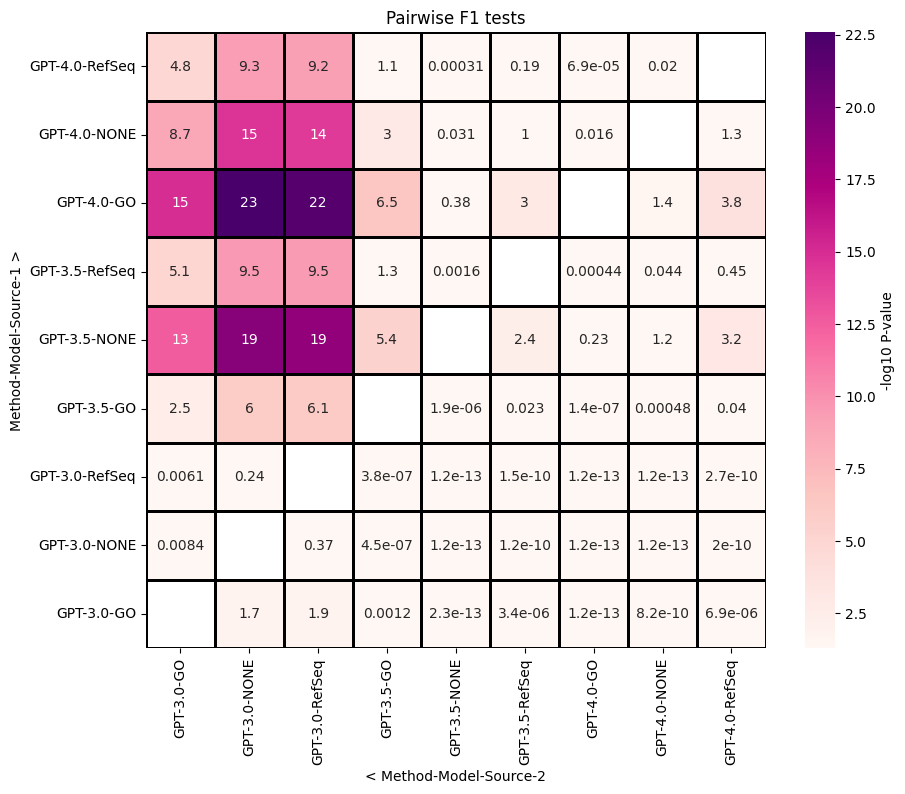

In [54]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise F1 tests")
plt.grid(False)
plt.savefig("TALISMAN_mw_f1.pdf", dpi=300, bbox_inches='tight')
plt.savefig("TALISMAN_mw_f1.png", dpi=300, bbox_inches='tight')

plt.show()

In [46]:
metrics = ['precision']

mu_precision_results = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        mu_stat, p_value = mannwhitneyu(group1_metric, group2_metric, alternative='greater', method='exact')
        #ttest_ind(group1_metric, group2_metric, 
        #                            nan_policy='propagate', permutations=100000, alternative='greater',
        #                           equal_var='false')
        
        # Store the results
        mu_precision_results.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'MU-Statistic': mu_stat,
            'P-Value': p_value,
        })



# Create a DataFrame to display the results
mu_precision_results_df = pd.DataFrame(mu_precision_results)

# Display the results
#print("Pairwise t-test results:")
#print(significant_results)

#print("pairs_with_na")
#print(pairs_with_na) = []

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/927507168.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: (

In [47]:
mu_precision_results_df['Method-Model-Source-1 >'] = mu_precision_results_df['Method1'].str.upper() + '-' + mu_precision_results_df['Model1'].astype(str) + '-' + mu_precision_results_df['Source1']
mu_precision_results_df['< Method-Model-Source-2'] = mu_precision_results_df['Method2'].str.upper() + '-' + mu_precision_results_df['Model2'].astype(str) + '-' + mu_precision_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = mu_precision_results_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,1.433809e-12,3.870708e-06,6.800278e-12,0.542139,0.996472,0.951552,0.661865,0.895829,0.500100
GPT-4.0-NONE,9.504815e-19,5.129585e-09,7.678469e-17,0.141677,0.940953,0.711811,0.157519,0.500100,0.104261
GPT-4.0-GO,1.317969e-20,4.769861e-09,1.439892e-17,0.372029,0.996185,0.905703,0.500100,0.842602,0.338501
GPT-3.5-RefSeq,7.251476e-15,3.493707e-08,1.856849e-14,0.077953,0.789862,0.500100,0.094465,0.288531,0.048499
GPT-3.5-NONE,3.356328e-23,4.560079e-12,6.314448e-21,0.007473,0.500100,0.210426,0.003826,0.059106,0.003533
GPT-3.5-GO,1.439563e-11,9.251817e-06,5.588644e-11,0.500100,0.992548,0.922120,0.628160,0.858435,0.458258
GPT-3.0-RefSeq,7.571989e-01,9.538276e-01,5.000998e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,1.246719e-01,5.000998e-01,4.622099e-02,0.999991,1.000000,1.000000,1.000000,1.000000,0.999996
GPT-3.0-GO,5.000998e-01,8.755338e-01,2.429577e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


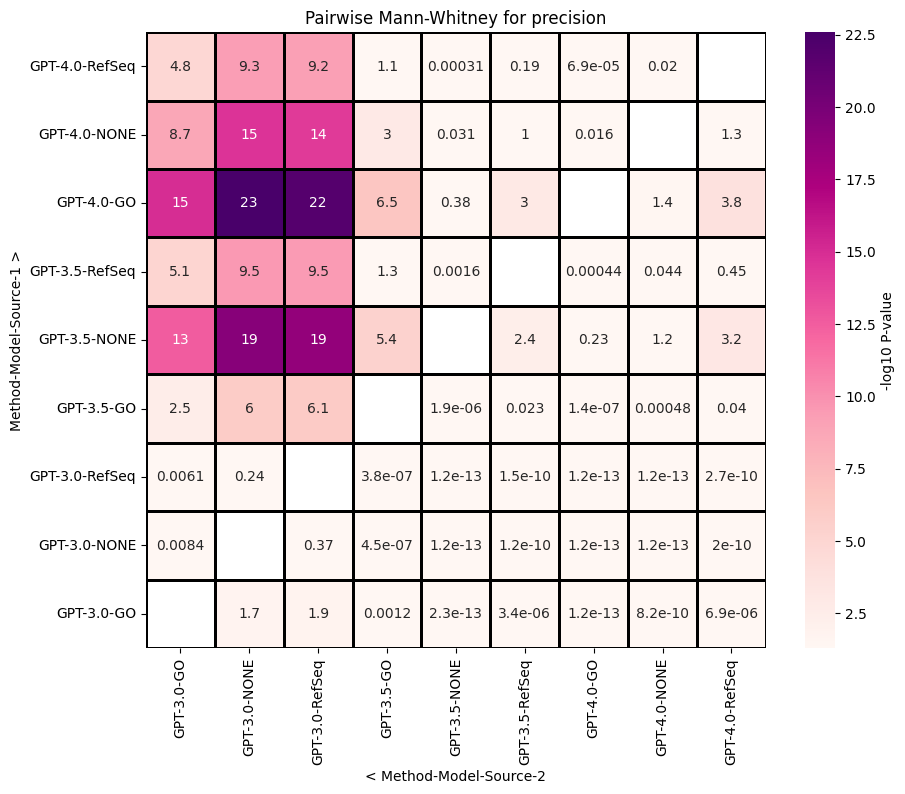

In [53]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise Mann-Whitney for precision")
plt.grid(False)
plt.savefig("TALISMAN_mw_precision.pdf", dpi=300, bbox_inches='tight')
plt.savefig("TALISMAN_mw_precision.png", dpi=300, bbox_inches='tight')

plt.show()

In [49]:
metrics = ['recall']

mu_recall_results = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        mu_stat, p_value = mannwhitneyu(group1_metric, group2_metric, alternative='greater', method='exact')
        #ttest_ind(group1_metric, group2_metric, 
        #                            nan_policy='propagate', permutations=100000, alternative='greater',
        #                           equal_var='false')
        
        # Store the results
        mu_recall_results.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'MU-Statistic': mu_stat,
            'P-Value': p_value,
        })



# Create a DataFrame to display the results
mu_recall_results_df = pd.DataFrame(mu_recall_results)

# Display the results
#print("Pairwise t-test results:")
#print(significant_results)

#print("pairs_with_na")
#print(pairs_with_na) = []

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_30154/3650592744.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: (

In [50]:
mu_recall_results_df['Method-Model-Source-1 >'] = mu_recall_results_df['Method1'].str.upper() + '-' + mu_recall_results_df['Model1'].astype(str) + '-' + mu_recall_results_df['Source1']
mu_recall_results_df['< Method-Model-Source-2'] = mu_recall_results_df['Method2'].str.upper() + '-' + mu_recall_results_df['Model2'].astype(str) + '-' + mu_recall_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = mu_recall_results_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,1.598837e-05,4.527806e-10,6.270949e-10,8.789491e-02,0.999295,0.645061,0.999842,0.954455,0.500100
GPT-4.0-NONE,1.891034e-09,2.438095e-15,4.964348e-15,1.098007e-03,0.931444,0.096163,0.964268,0.500100,0.045593
GPT-4.0-GO,1.049541e-15,2.602776e-23,1.410098e-22,3.307530e-07,0.414142,0.001021,0.500100,0.035771,0.000159
GPT-3.5-RefSeq,7.755029e-06,2.869443e-10,3.401334e-10,5.144431e-02,0.996375,0.500100,0.998981,0.903922,0.355125
GPT-3.5-NONE,2.517499e-13,6.612262e-20,2.299111e-19,4.388999e-06,0.500100,0.003630,0.586053,0.068622,0.000707
GPT-3.5-GO,2.879935e-03,1.029714e-06,8.804564e-07,5.000998e-01,0.999996,0.948661,1.000000,0.998906,0.912265
GPT-3.0-RefSeq,9.859909e-01,5.758877e-01,5.000998e-01,9.999991e-01,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,9.808204e-01,5.000998e-01,4.245043e-01,9.999990e-01,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,5.000998e-01,1.922653e-02,1.404496e-02,9.971289e-01,1.000000,0.999992,1.000000,1.000000,0.999984


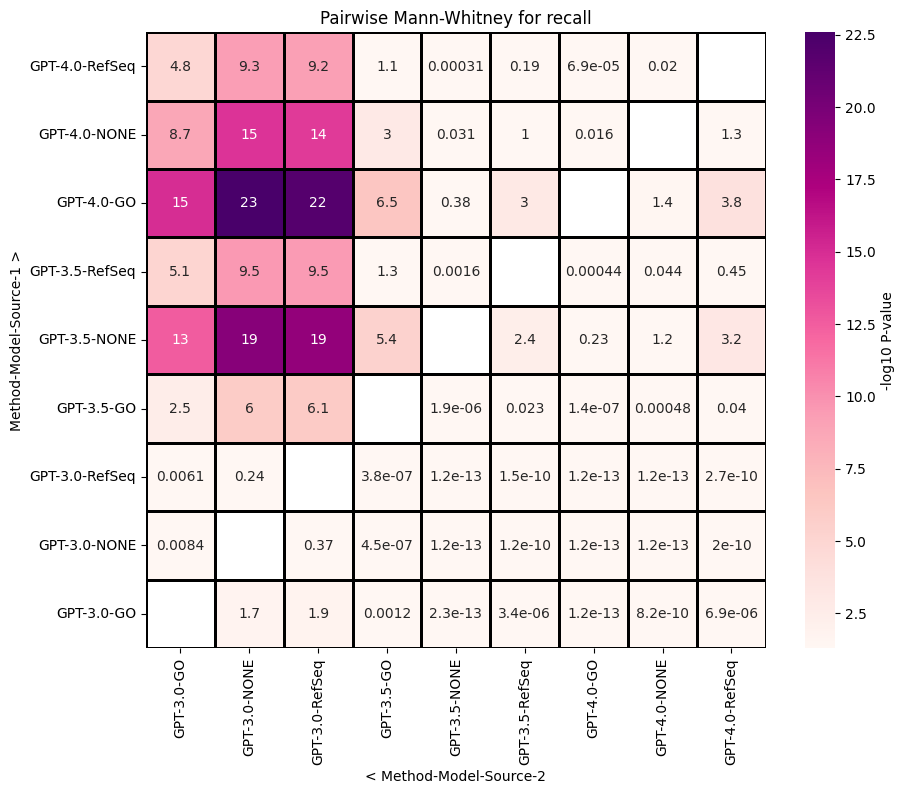

In [52]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise Mann-Whitney for recall")
plt.grid(False)
plt.savefig("TALISMAN_mw_recall.pdf", dpi=300, bbox_inches='tight')
plt.savefig("TALISMAN_mw_recall.png", dpi=300, bbox_inches='tight')

plt.show()